In [1]:
#import relevant packages and libraies
import os
import re
import cv2
import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import tensorflow.keras as keras
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from tensorflow.keras.applications import mobilenet_v2
from keras.preprocessing.image import ImageDataGenerator


from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


In [2]:
situations = {
                'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'
}

In [3]:
X = []
y = []
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
base_path = './data/train/'

for i, target in enumerate(classes):
    
    files = os.listdir(base_path+target)
    
    print(f'we are now in {target} class')
    
    for file in files:
        
        # load the image
        img = load_img(base_path+target + '/' + file, target_size=(224, 224))
        
        #convert it to an array
        img_array = np.array(img)
              
        # append the array to X
        X.append(img_array)
        
        # append the numeric target to y
        y.append(i) 
        
print('finished')

we are now in c0 class
we are now in c1 class
we are now in c2 class
we are now in c3 class
we are now in c4 class
we are now in c5 class
we are now in c6 class
we are now in c7 class
we are now in c8 class
we are now in c9 class
finished


In [4]:
X = np.array(X)
y = np.array(y)

In [5]:
# shuffle the data
shuffler = np.random.permutation(len(X))
X = X[shuffler]
y = y[shuffler]

In [6]:
# train-test split
from sklearn.model_selection import train_test_split
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X, y, test_size=0.90)

In [7]:
X_train,X_test, y_train, y_test = train_test_split(X_train_sample,y_train_sample, test_size=0.20)

In [8]:
#keep a copy of y test as the actual number labels for further process
y_test_true = y_test.copy()

In [9]:
#one hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [10]:
#scaling
X_train = X_train.astype('float32')/255

In [11]:
X_test = X_test.astype('float32')/255

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1793, 224, 224, 3), (1793, 10), (449, 224, 224, 3), (449, 10))

# MobilenetV2

In [13]:
#clear session 
K.clear_session()

In [14]:
# number of possible label values
nb_classes = 10

#designing the layers and build model
base_model = mobilenet_v2.MobileNetV2(weights='imagenet',include_top=False)

output = base_model.output
output = GlobalAveragePooling2D()(output)

final = Dense(nb_classes,activation='softmax')(output) #final layer with softmax activation

model = Model(inputs=base_model.input, outputs=final)


9420800/9406464 [==============================] - 2s 0us/step


In [15]:
#check the summary:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, None, None, 3 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [16]:
#compile the model
model.compile(optimizer=SGD(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
#define early stopping for fitting
early_stop = keras.callbacks.EarlyStopping(
                                            monitor='val_loss', 
                                            min_delta=0.0005, 
                                            patience=10,
                                            verbose=1, 
                                            mode='auto',
                                           )

In [20]:
datagen = ImageDataGenerator(
                            height_shift_range=0.5,
                            width_shift_range = 0.5,
                            zoom_range = 0.5,
                            rotation_range=30
                            )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 32)

# Fits the model on batches with real-time data augmentation:
history = model.fit_generator(
                               data_generator,
                               steps_per_epoch=len(X_train)/32, 
                               callbacks=[early_stop],
                               epochs = 50,
                               validation_data = (X_test, y_test)
                              )

Epoch 1/50
56/56 [==============================] - 197s 3s/step - loss: 2.5105 - accuracy: 0.1060 - val_loss: 2.5533 - val_accuracy: 0.1381
Epoch 2/50
56/56 [==============================] - 195s 3s/step - loss: 2.3925 - accuracy: 0.1288 - val_loss: 2.4295 - val_accuracy: 0.1537
Epoch 3/50
56/56 [==============================] - 194s 3s/step - loss: 2.3581 - accuracy: 0.1405 - val_loss: 2.3670 - val_accuracy: 0.1604
Epoch 4/50
56/56 [==============================] - 194s 3s/step - loss: 2.3076 - accuracy: 0.1617 - val_loss: 2.3026 - val_accuracy: 0.1759
Epoch 5/50
56/56 [==============================] - 194s 3s/step - loss: 2.2687 - accuracy: 0.1651 - val_loss: 2.2489 - val_accuracy: 0.1982
Epoch 6/50
56/56 [==============================] - 194s 3s/step - loss: 2.2169 - accuracy: 0.1941 - val_loss: 2.1824 - val_accuracy: 0.2339
Epoch 7/50
56/56 [==============================] - 194s 3s/step - loss: 2.1835 - accuracy: 0.2075 - val_loss: 2.1222 - val_accuracy: 0.2517
Epoch 8/50
56

In [21]:
model.save('./models/model_mobilnet_v2.h5')

In [22]:
ypred = model.predict(X_test)

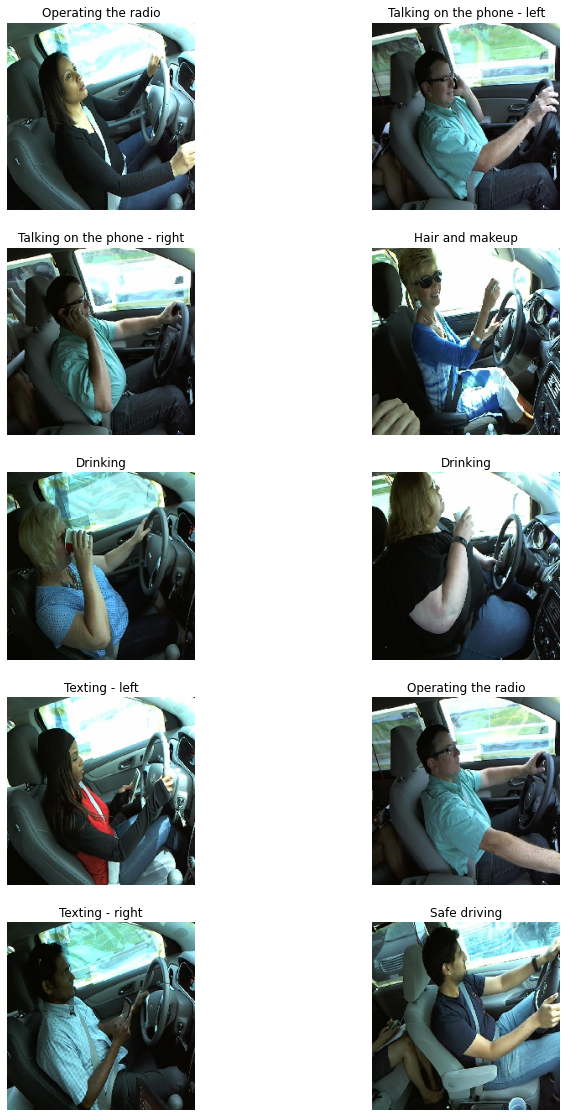

In [23]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,20
# have a look at the data
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(situations[classes[np.argmax(ypred[i])]]) 

# Examine the model

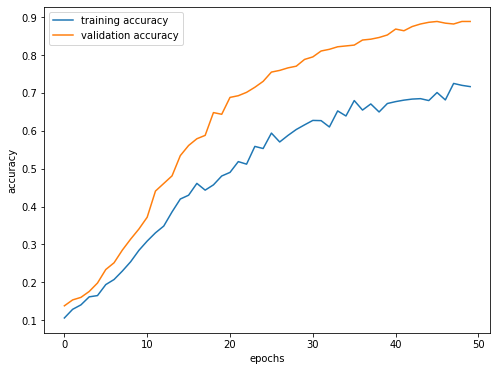

In [24]:
#plot accuracy curve
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label= 'validation accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()


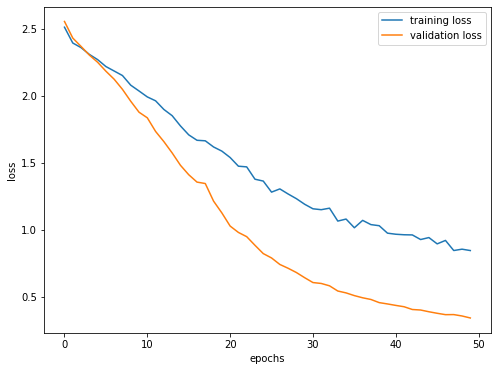

In [25]:
# Plot loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [26]:
true_list =[]
for i in range(len(y_test_true)):
    if np.argmax(ypred[i])==y_test_true[i]:
        true_list.append(i)
        
probability = len(true_list) / len(y_test_true)
round(probability,3)

0.889

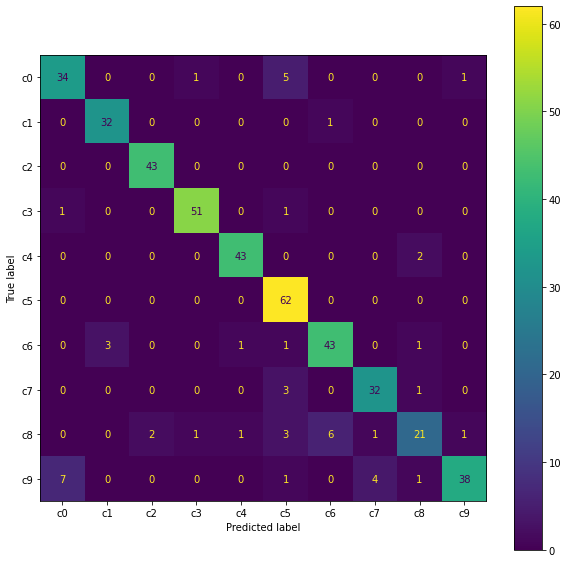

In [27]:
#plot confusion matrix
cm = confusion_matrix(y_true=y_test_true, y_pred=np.argmax(ypred, axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=classes)
fig, ax = plt.subplots(figsize=(10,10))

disp.plot(ax=ax);

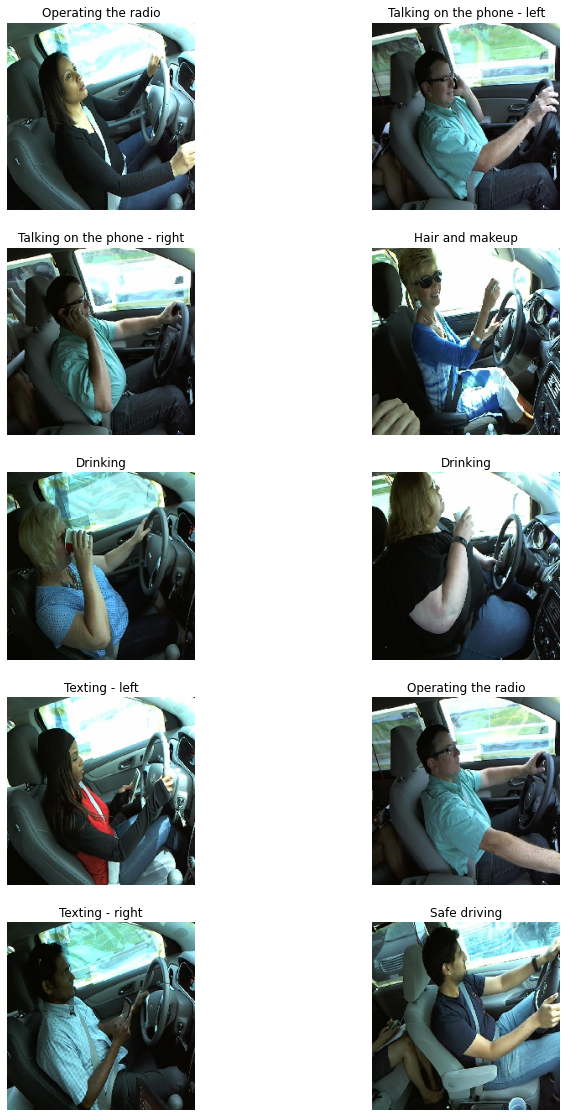

In [28]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,20
# have a look at the data
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(situations[classes[np.argmax(ypred[i])]]) 

In [29]:
history.history

{'loss': [2.5104806423187256,
  2.3925490379333496,
  2.358119487762451,
  2.3076398372650146,
  2.2686893939971924,
  2.216949224472046,
  2.1835291385650635,
  2.149885892868042,
  2.0778439044952393,
  2.0346226692199707,
  1.9904146194458008,
  1.9612963199615479,
  1.8968217372894287,
  1.8503957986831665,
  1.7740849256515503,
  1.7074841260910034,
  1.666919469833374,
  1.6629793643951416,
  1.6170434951782227,
  1.586067795753479,
  1.5383284091949463,
  1.4735296964645386,
  1.4685046672821045,
  1.3764976263046265,
  1.3626246452331543,
  1.2801045179367065,
  1.304175853729248,
  1.2663670778274536,
  1.2312978506088257,
  1.1896120309829712,
  1.1558104753494263,
  1.1491122245788574,
  1.1603800058364868,
  1.0641638040542603,
  1.0792704820632935,
  1.0142951011657715,
  1.0694036483764648,
  1.037783145904541,
  1.029603123664856,
  0.9740188121795654,
  0.9659873843193054,
  0.9621139764785767,
  0.9608739018440247,
  0.9264683127403259,
  0.9411650896072388,
  0.894089

In [ ]:
history_x = {'loss': [2.5104806423187256,
  2.3925490379333496,
  2.358119487762451,
  2.3076398372650146,
  2.2686893939971924,
  2.216949224472046,
  2.1835291385650635,
  2.149885892868042,
  2.0778439044952393,
  2.0346226692199707,
  1.9904146194458008,
  1.9612963199615479,
  1.8968217372894287,
  1.8503957986831665,
  1.7740849256515503,
  1.7074841260910034,
  1.666919469833374,
  1.6629793643951416,
  1.6170434951782227,
  1.586067795753479,
  1.5383284091949463,
  1.4735296964645386,
  1.4685046672821045,
  1.3764976263046265,
  1.3626246452331543,
  1.2801045179367065,
  1.304175853729248,
  1.2663670778274536,
  1.2312978506088257,
  1.1896120309829712,
  1.1558104753494263,
  1.1491122245788574,
  1.1603800058364868,
  1.0641638040542603,
  1.0792704820632935,
  1.0142951011657715,
  1.0694036483764648,
  1.037783145904541,
  1.029603123664856,
  0.9740188121795654,
  0.9659873843193054,
  0.9621139764785767,
  0.9608739018440247,
  0.9264683127403259,
  0.9411650896072388,
  0.8940896987915039,
  0.9198799133300781,
  0.8444629311561584,
  0.854506254196167,
  0.8443320989608765],
 'accuracy': [0.10596764832735062,
  0.12883435189723969,
  0.14054657518863678,
  0.16174009442329407,
  0.16508644819259644,
  0.19408811628818512,
  0.2074735015630722,
  0.22978249192237854,
  0.254322350025177,
  0.28443947434425354,
  0.3089793622493744,
  0.3307306170463562,
  0.3485777974128723,
  0.3859453499317169,
  0.41996654868125916,
  0.43000558018684387,
  0.46123814582824707,
  0.44339096546173096,
  0.45733407139778137,
  0.48075851798057556,
  0.49023982882499695,
  0.5186837911605835,
  0.5119910836219788,
  0.5588399171829224,
  0.5532627105712891,
  0.5939765572547913,
  0.5705521702766418,
  0.5878416299819946,
  0.6034578680992126,
  0.6157278418540955,
  0.6274400353431702,
  0.6268823146820068,
  0.6101505756378174,
  0.6525376439094543,
  0.6391522884368896,
  0.6798661351203918,
  0.6547685265541077,
  0.6709425449371338,
  0.6497490406036377,
  0.6720579862594604,
  0.6770775318145752,
  0.6809815764427185,
  0.6837702393531799,
  0.6848856806755066,
  0.6798661351203918,
  0.7010596990585327,
  0.6815392971038818,
  0.7250418066978455,
  0.7200223207473755,
  0.7166759371757507],
 'val_loss': [2.553257465362549,
  2.4295129776000977,
  2.367011785507202,
  2.302625894546509,
  2.2489216327667236,
  2.1823647022247314,
  2.122171401977539,
  2.0467793941497803,
  1.9579626321792603,
  1.876311182975769,
  1.834507942199707,
  1.7328609228134155,
  1.6568913459777832,
  1.5725815296173096,
  1.4804630279541016,
  1.4100593328475952,
  1.3549368381500244,
  1.3442867994308472,
  1.2130330801010132,
  1.125219702720642,
  1.0269379615783691,
  0.9794206619262695,
  0.9478828310966492,
  0.883486270904541,
  0.8216320276260376,
  0.7890334725379944,
  0.7406719326972961,
  0.7121809720993042,
  0.6804168820381165,
  0.6417934894561768,
  0.6055656671524048,
  0.5988222360610962,
  0.5811983942985535,
  0.5424364805221558,
  0.5283575654029846,
  0.508158802986145,
  0.49192777276039124,
  0.47936898469924927,
  0.4558786451816559,
  0.4459945857524872,
  0.4351258873939514,
  0.42516764998435974,
  0.4045551121234894,
  0.40068504214286804,
  0.3877352774143219,
  0.3763275742530823,
  0.3660525381565094,
  0.3665942847728729,
  0.3562190532684326,
  0.34132707118988037],
 'val_accuracy': [0.13808463513851166,
  0.15367482602596283,
  0.160356342792511,
  0.17594654858112335,
  0.19821825623512268,
  0.23385301232337952,
  0.25167039036750793,
  0.2850779592990875,
  0.314031183719635,
  0.34075725078582764,
  0.37193763256073,
  0.4409799575805664,
  0.4610244929790497,
  0.48106902837753296,
  0.5345211625099182,
  0.5612472295761108,
  0.5790646076202393,
  0.5879732966423035,
  0.6481069326400757,
  0.6436525583267212,
  0.6881960034370422,
  0.692650318145752,
  0.7015590071678162,
  0.7149220705032349,
  0.730512261390686,
  0.7550111413002014,
  0.7594654560089111,
  0.7661470174789429,
  0.7706013321876526,
  0.788418710231781,
  0.795100212097168,
  0.8106904029846191,
  0.8151447772979736,
  0.8218262791633606,
  0.8240534663200378,
  0.8262805938720703,
  0.839643657207489,
  0.8418708443641663,
  0.846325159072876,
  0.8530066609382629,
  0.8685969114303589,
  0.8641425371170044,
  0.8752784132957458,
  0.8819599151611328,
  0.8864142298698425,
  0.8886414170265198,
  0.8841871023178101,
  0.8819599151611328,
  0.8886414170265198,
  0.8886414170265198]}